# Imports

In [221]:
from win32com.client import Dispatch
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches

# Constants
meter = 1
millimeter = 1e-3 * meter
micron = 1e-6 * meter
deg = np.pi / 180
arcsec = deg / 3600
hourangle = deg * 15
secangle = hourangle / 3600

# Telescope parameters
plate_scale = 1 / (2939 * millimeter) # Radians per meter
pixel = 9 * micron

# Single fiber (one of 20)
single_fiber_diam = 50 * micron
single_fiber_arcsec = single_fiber_diam * plate_scale / arcsec

# Location parameters
obs_lat=41.6620165; obs_lon=-91.5325033 # Iowa City

# Connect to camera

In dialog, set ZWO 290MM Mini to 350 gain, 240 offset to prevent clipping negative values. Or max out gain to get higher counts... Also be sure that the image readout mode is set to 16bit. (in reality it's only 12bit, but the 16bit mode is what allows the camera to read out the full 12bit range)

In [215]:
# Connect to ASCOM camera
fiber_camera = Dispatch('ASCOM.ASICamera2.Camera')

# Open setup dialog
fiber_camera.SetupDialog()

In [216]:
if fiber_camera.Connected:
    print('Camera is already connected')
else:
    fiber_camera.Connected = True
    if fiber_camera.Connected:
        print('Camera is connected')
    else:
        print('Camera is not connected, try again')


Camera is connected


In [217]:
# Get camera properties
print('Camera properties:')
print('Camera name: ', fiber_camera.Name)
print('Camera description: ', fiber_camera.Description)
print('Camera driver info: ', fiber_camera.DriverInfo)
print('Camera interface version: ', fiber_camera.InterfaceVersion)
print('Camera driver version: ', fiber_camera.DriverVersion)
print('Camera sensor name: ', fiber_camera.SensorName)
print('Camera sensor type: ', fiber_camera.SensorType)
print('Camera readout mode: ', fiber_camera.ReadoutMode)

Camera properties:
Camera name:  ZWO ASI290MM Mini
Camera description:  ASI Camera (1)
Camera driver info:  ASI Camera (1)6.5
Camera interface version:  3
Camera driver version:  6.5
Camera sensor name:  
Camera sensor type:  0
Camera readout mode:  0


In [218]:
# Read bin mode
print('Camera bin mode: ', fiber_camera.BinX, 'x', fiber_camera.BinY)

Camera bin mode:  1 x 1


## Camera setup

Connect fiber to camera, shine light into fiber and adjust exposure time until you see a circle of light on the camera. We will define the center of the circle and radius programmatically (hopefully). Otherwise, there is a backup click/drag method.

In [219]:
# Function to take and download image
def take_image(exposure_time):
    fiber_camera.StartExposure(exposure_time, True)
    while fiber_camera.ImageReady == False:
        time.sleep(0.1)
    img = fiber_camera.ImageArray
    img = np.array(img)
    img = np.rot90(img, 1)
    return img

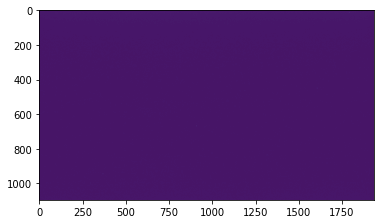

In [222]:
img = take_image(1)

# Plot image
plt.imshow(img, cmap='viridis')
plt.show()

In [223]:
# Count number of pixels at value
value = 16
print('Number of pixels at value ', value, ': ', np.count_nonzero(img == value))

Number of pixels at value  16 :  2


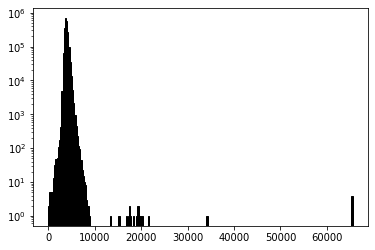

In [224]:
# Plot histogram of image with log scale on y-axis
plt.hist(img.ravel(), bins=256, range=(0.0, 65536.0), fc='k', ec='k')
plt.yscale('log')
plt.show()

In [225]:
# Create widget to draw circle on image and reposition it, as well as save
# the x, y, and r values
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def draw_circle(x, y, r):
    plt.imshow(img, cmap='viridis')
    circle = plt.Circle((x, y), r, color='r', fill=False)
    plt.gcf().gca().add_artist(circle)
    # Make figure larger
    plt.gcf().set_size_inches(10, 10)
    plt.show()
    return [x, y, r]

# Get max x and y dimensions from camera
max_x = fiber_camera.CameraXSize
max_y = fiber_camera.CameraYSize

circle_selector = interactive(draw_circle, x=widgets.IntSlider(min=0, max=max_x, step=1, value=max_x/2),
                               y=widgets.IntSlider(min=0, max=max_y, step=1, value=max_y/2), 
                               r=widgets.IntSlider(min=0, max=1024, step=1, value=256),
                               continuous_update=False)


In [226]:
display(circle_selector)

interactive(children=(IntSlider(value=968, description='x', max=1936), IntSlider(value=548, description='y', m…

In [227]:
# Print average, median, and standard deviation of pixels in box around fiber (circle is too hard)

[fiber_x, fiber_y, fiber_r] = circle_selector.result

# Get box around fiber
fiber_box = img[fiber_y-fiber_r:fiber_y+fiber_r, fiber_x-fiber_r:fiber_x+fiber_r]

# Print average, median, and standard deviation of pixels in box around fiber
print('Average: %.2f' % np.average(fiber_box))
print('Median: %2d' % np.median(fiber_box))
print('Standard deviation: %2d' % np.std(fiber_box))


Average: 3813.29
Median: 3792
Standard deviation: 326


In [250]:
# Make numpy array to store average, median, and standard deviation of pixels in box around fiber
# for multiple images. We will append to this array each time we take an image.
# We will use this array to plot the average, median, and standard deviation of pixels in box around fiber
# as a function of exposure time.
fiber_stats = np.empty((0, 3), float)

# On function call, take image, show image, and print average, median, and standard deviation of pixels in box around fiber
def take_image_and_print_stats(exposure_time, fiber_x, fiber_y, fiber_r, fiber_stats):
    '''Take image, plot image, and print average, median, and standard deviation of pixels in box around fiber

    Parameters:
    exposure_time (float): Exposure time in seconds
    '''
    # This is supposed to wait to clear the current output until new output is available, but it doesn't seem to work
    clear_output(wait=True) 

    # Take image, plot image
    img = take_image(exposure_time)

    # Set parameters for log stretch based on image statistics
    # Set minimum value to 1
    min_value = np.percentile(img, 5)
    # Set maximum value to 99th percentile
    max_value = np.percentile(img, 99)

    # Plot image, set log stretch
    plt.imshow(img, cmap='inferno', norm=LogNorm(vmin=min_value, vmax=max_value))
    
    # Use linear stretch
    #plt.imshow(img, cmap='inferno', vmin=min_value, vmax=max_value)
    
    # Show box around fiber
    plt.plot([fiber_x-fiber_r, fiber_x+fiber_r, fiber_x+fiber_r, fiber_x-fiber_r, fiber_x-fiber_r],
                [fiber_y-fiber_r, fiber_y-fiber_r, fiber_y+fiber_r, fiber_y+fiber_r, fiber_y-fiber_r], 'r', linewidth=1)
    # Make figure larger
    plt.gcf().set_size_inches(15, 10)
    plt.colorbar()
    plt.gcf()

    # Statistics
    [fiber_x, fiber_y, fiber_r] = circle_selector.result
    fiber_box = img[fiber_y-fiber_r:fiber_y+fiber_r, fiber_x-fiber_r:fiber_x+fiber_r]
    print('Average: %.2f' % np.average(fiber_box))
    print('Median: %2d' % np.median(fiber_box))
    print('Standard deviation: %2d' % np.std(fiber_box))

    # Append average, median, and standard deviation of pixels in box around fiber to fiber_stats
    fiber_stats = np.append(fiber_stats, [[np.average(fiber_box), np.median(fiber_box), np.std(fiber_box)]], axis=0)
    return fiber_stats

## Get image/save statistics

Statistics save to fiber_stats array (defined above) in the form [average, median, std]. Rerun above cell to reset statistics.

Average: 3681.93
Median: 3680
Standard deviation: 240


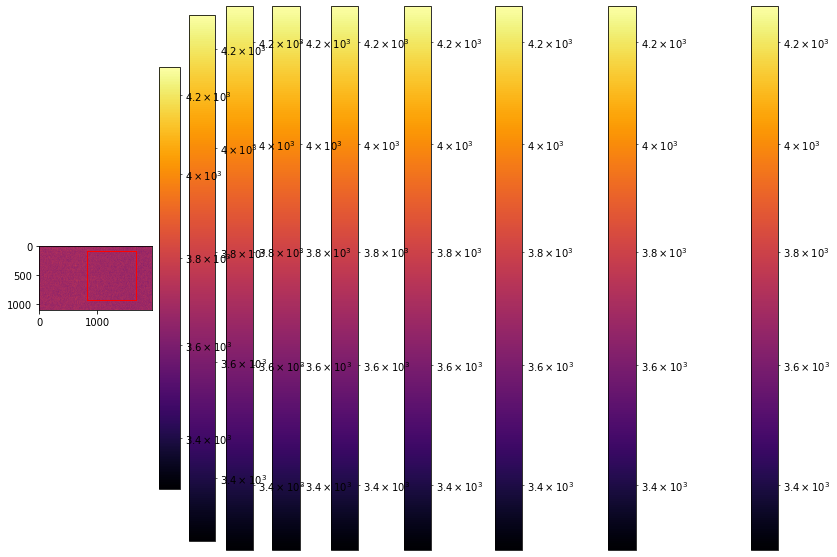

In [266]:
for i in range(1, 10):
    fiber_stats = take_image_and_print_stats(0.001, fiber_x, fiber_y, fiber_r, fiber_stats)
    time.sleep(5)

In [270]:
print(fiber_stats)

[[3836.94240363 3808.          337.28535816]
 [3838.4314966  3808.          340.32113103]
 [3838.1778458  3808.          339.58836898]
 [3841.57353741 3808.          340.52826214]
 [3842.72306122 3824.          341.10195455]
 [3843.55628118 3824.          343.74589747]
 [3845.71419501 3824.          343.41992481]
 [3846.58680272 3824.          342.90235015]
 [3847.47943311 3824.          343.57299928]
 [3836.19018141 3808.          337.62053694]
 [3840.03582766 3808.          340.27262084]
 [3839.78040816 3808.          339.87835364]
 [3842.10820862 3808.          340.44676195]
 [3842.52356009 3808.          341.74337627]
 [3846.8500907  3824.          343.0851091 ]
 [3846.50743764 3824.          342.97158396]
 [3847.87535147 3824.          344.6949365 ]
 [3848.29421769 3824.          343.76630326]
 [3843.67519274 3824.          342.27703051]
 [3845.55349206 3824.          342.67789428]
 [3850.65528345 3824.          345.56857744]
 [3851.66922902 3824.          345.45735274]
 [3851.139

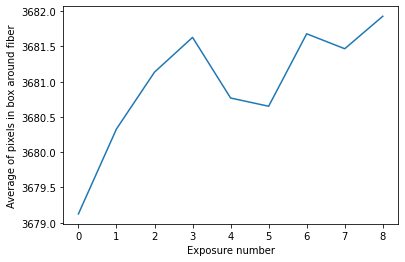

In [269]:
# Plot average of pixels in box around fiber
plt.plot(fiber_stats[63:, 0])
plt.xlabel('Exposure number')
plt.ylabel('Average of pixels in box around fiber')
plt.show()

Average: 4232.38
Median: 4160
Standard deviation: 537


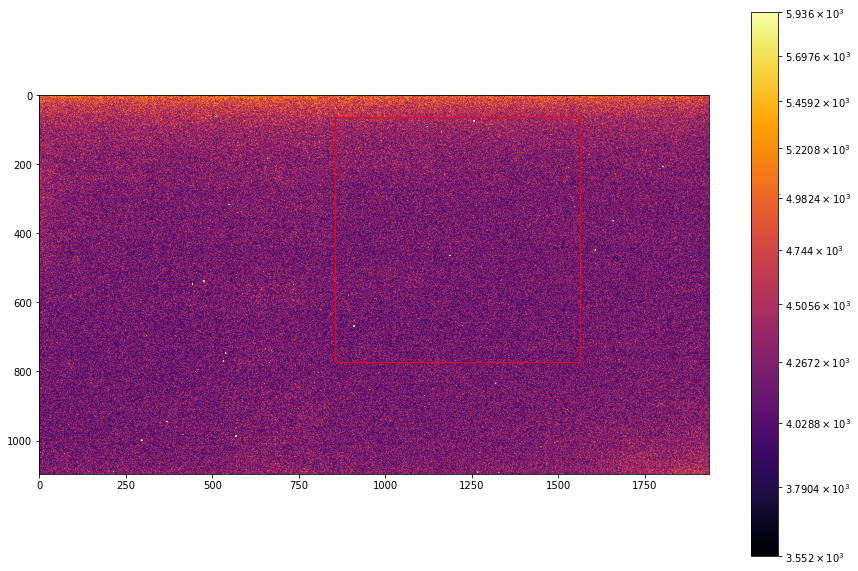

In [162]:
take_image_and_print_stats(5, fiber_x, fiber_y, fiber_r)

Average: 4233.69
Median: 4160
Standard deviation: 538


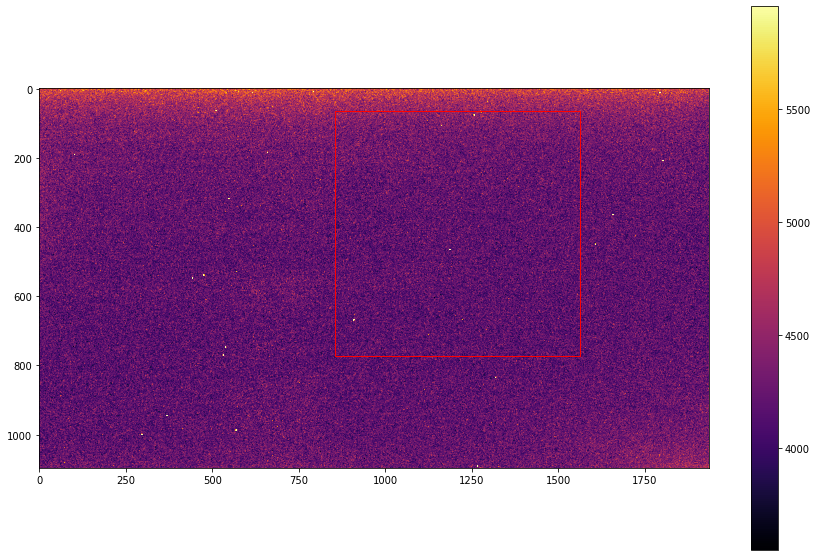

In [164]:
take_image_and_print_stats(5, fiber_x, fiber_y, fiber_r)

In [167]:
# Disconnect camera
fiber_camera.Connected = False
if fiber_camera.Connected:
    print('Camera is connected')
else:
    print('Camera is not connected')

Camera is not connected


# 20 Fiber Bundle

In [47]:
# Generate a linear array of 20 circles of diameter 50 microns
# Each stacked on top of each other
# Also allow for a rotation angle to be specified
# Also allow for a center position to be specified

def generate_linear_fiber(center_x, center_y, theta):
    '''Function to generate a list of [x,y,r] values for a linear array of circles

    Parameters:
    center_x (float): Center x position of fiber
    center_y (float): Center y position of fiber
    theta (float): Rotation angle of fiber in degrees, clockwise from vertical

    Returns:
    fiber_list (list): Array of [x,y,r] values for a linear array of circles
    '''
    
    # Define fiber parameters
    fiber_diameter = 50 * micron # microns
    fiber_separation = 50 * micron # microns
    fiber_number = 20 # number of fibers
    theta = theta * deg # degrees

    # Define fiber list
    fiber_list = []

    # If odd number of fibers, center middle fiber on center position
    if fiber_number % 2 == 1:
        for i in range(-int(fiber_number/2), int(fiber_number/2)+1):
            # Append [x,y,r] values to fiber list
            fiber_list.append([center_x, center_y + i*fiber_separation, fiber_diameter/2])
            
    else: # If even number of fibers, center middle two fibers on center position
        # Use i values at half integer values to center middle two fibers
        for i in np.arange(-fiber_number/2+0.5, fiber_number/2+0.5, 1):
            fiber_list.append([center_x, center_y + i*fiber_separation, fiber_diameter/2])

    # Flip order of list so that fiber 1 is on top
    fiber_list = fiber_list[::-1]

    # Change to np array
    fiber_list = np.array(fiber_list)

    # Rotate fiber list
    # Translate fiber list so that center of fiber is at origin
    fiber_list = fiber_list - [center_x, center_y, 0]
    # Rotate fiber list
    fiber_list = np.matmul(fiber_list, np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]]))
    # Translate fiber list back to original position
    fiber_list = fiber_list + [center_x, center_y, 0]

    return fiber_list


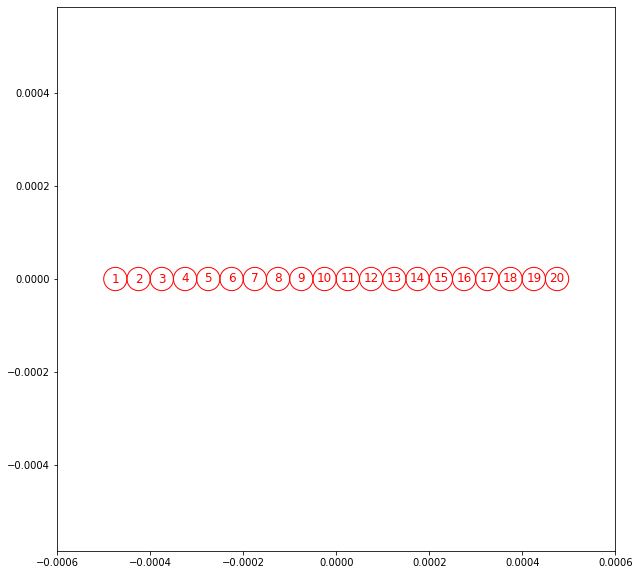

In [49]:
fiber_list = generate_linear_fiber(0, 0, 270)

# Plot fiber list
plt.figure()
for i in range(len(fiber_list)):
    [x, y, r] = fiber_list[i]
    # Plot circles at each fiber position
    circle = plt.Circle((x, y), r, color='r', fill=False)
    plt.gcf().gca().add_artist(circle)
    # Label each fiber with a number from 1 to 20
    plt.text(x, y, str(i+1), color='r', fontsize=12, horizontalalignment='center', verticalalignment='center')
# Make figure larger
plt.gcf().set_size_inches(10, 10)

# Set axis limits to +/- 600 microns
plt.xlim([-600*micron, 600*micron])
plt.ylim([-600*micron, 600*micron])
plt.axis('equal')

plt.show()

In [40]:
len(fiber_list)

60

In [41]:
print(fiber_list)

[ 2.50e-05  4.75e-04  0.00e+00  2.50e-05  4.25e-04  0.00e+00  2.50e-05
  3.75e-04  0.00e+00  2.50e-05  3.25e-04  0.00e+00  2.50e-05  2.75e-04
  0.00e+00  2.50e-05  2.25e-04  0.00e+00  2.50e-05  1.75e-04  0.00e+00
  2.50e-05  1.25e-04  0.00e+00  2.50e-05  7.50e-05  0.00e+00  2.50e-05
  2.50e-05  0.00e+00  2.50e-05 -2.50e-05  0.00e+00  2.50e-05 -7.50e-05
  0.00e+00  2.50e-05 -1.25e-04  0.00e+00  2.50e-05 -1.75e-04  0.00e+00
  2.50e-05 -2.25e-04  0.00e+00  2.50e-05 -2.75e-04  0.00e+00  2.50e-05
 -3.25e-04  0.00e+00  2.50e-05 -3.75e-04  0.00e+00  2.50e-05 -4.25e-04
  0.00e+00  2.50e-05 -4.75e-04  0.00e+00]


In [71]:
# Generate circular fiber array
# Allow for a rotation angle to be specified
# Allow for a center position to be specified

def generate_circular_fiber(center_x, center_y, theta):
    '''Function to generate a list of [x,y,r] values for a circular array of circles

    Parameters:
    center_x (float): Center x position of fiber
    center_y (float): Center y position of fiber
    theta (float): Rotation angle of fiber in degrees, clockwise from vertical

    Returns:
    fiber_list (np.array): Array of [x,y,r] values for a circular array of circles
    '''

    # Define fiber parameters
    fiber_diameter = 50 * micron # microns
    fiber_ring_separation = 50 * micron # microns
    fiber_ring_numbers = [1, 6, 12] # number of fibers in each ring
    theta = theta * deg # degrees

    # Define fiber list
    fiber_list = []

    # Loop through each ring
    for i in range(len(fiber_ring_numbers)):
        # Loop through each fiber in ring
        for j in range(fiber_ring_numbers[i]):
            # Append [x,y,r] values to fiber list
            fiber_list.append([center_x + (i)*fiber_ring_separation*np.sin(j*2*np.pi/fiber_ring_numbers[i] + theta),
                               center_y + (i)*fiber_ring_separation*np.cos(j*2*np.pi/fiber_ring_numbers[i] + theta),
                               fiber_diameter/2])
            
    # Change to np array
    fiber_list = np.array(fiber_list)

    return fiber_list


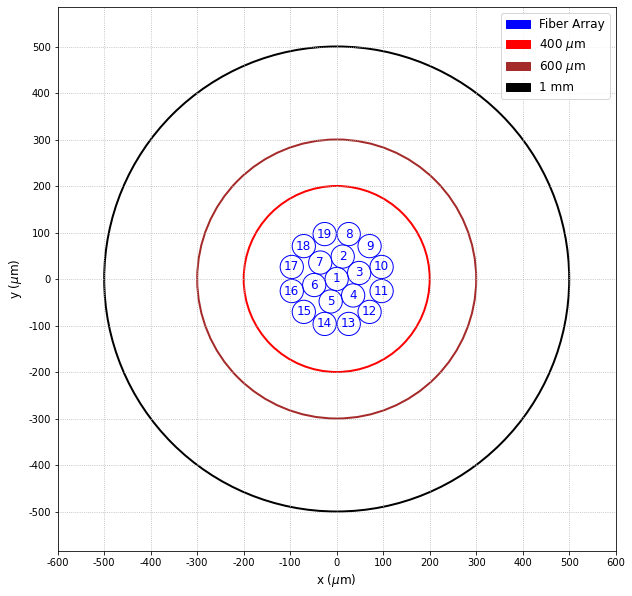

In [182]:
fiber_list = generate_circular_fiber(0,0,15)

# Plot fiber list
plt.figure()
for i in range(len(fiber_list)):
    [x, y, r] = fiber_list[i]
    # Plot circles at each fiber position
    circle = plt.Circle((x, y), r, color='b', fill=False)
    plt.gcf().gca().add_artist(circle)
    # Label each fiber with a number from 1 to 20
    plt.text(x, y, str(i+1), color='b', fontsize=12, horizontalalignment='center', verticalalignment='center')
# Make figure larger
plt.gcf().set_size_inches(10, 10)

# Plot 1 mm circle
circle = plt.Circle((0, 0), 500*micron, color='k', fill=False, linewidth=2)
plt.gcf().gca().add_artist(circle)

# Plot 600 micron circle with brown color
circle = plt.Circle((0, 0), 300*micron, color='brown', fill=False, linewidth=2)
plt.gcf().gca().add_artist(circle)

# Plot 400 micron circle in red
circle = plt.Circle((0, 0), 200*micron, color='r', fill=False, linewidth=2)
plt.gcf().gca().add_artist(circle)

# Set axis limits to +/- 600 microns
plt.xlim([-600*micron, 600*micron])
plt.ylim([-600*micron, 600*micron])
plt.axis('equal')

# Add legend, with blue for fiber array, red for 400 micron circle, and brown for 600 micron circle, black for 1 mm circle
blue_patch = mpatches.Patch(color='b', label='Fiber Array')
red_patch = mpatches.Patch(color='r', label='400 $\mu$m')
brown_patch = mpatches.Patch(color='brown', label='600 $\mu$m')
black_patch = mpatches.Patch(color='k', label='1 mm')
plt.legend(handles=[blue_patch, red_patch, brown_patch, black_patch], loc='upper right', fontsize=12)

# Set axis labels to be in microns
plt.xlabel('x ($\mu$m)', fontsize=12)
plt.ylabel('y ($\mu$m)', fontsize=12)

# Multiply axis labels by 1000 to convert to microns, round to nearest micron, and convert to integer
plt.xticks(np.arange(-600*micron, 700*micron, 100*micron), np.round(np.arange(-600, 700, 100), 0).astype(int))
plt.yticks(np.arange(-600*micron, 700*micron, 100*micron), np.round(np.arange(-600, 700, 100), 0).astype(int))

# Add grid lines (dotted)
plt.grid(linestyle='dotted')

plt.show()

# Get coordinates of each fiber

In [204]:
from astropy import coordinates as coord, time
import astropy.units as u

# Get coordinates of Arcturus
obj = coord.SkyCoord.from_name('Polaris')
obj_now = obj.transform_to(coord.TETE(obstime=time.Time.now(), location=coord.EarthLocation.from_geodetic(lat=obs_lat, lon=obs_lon)))

D = 28.047 * millimeter # 27.2 from my drawing
theta = (26.889+90) * deg

# Guess nominal ra and dec from above geometry
nominal_dec = -D * np.sin(theta) * plate_scale
nominal_ra = D * np.cos(theta) * plate_scale / np.cos(obj.dec.rad)

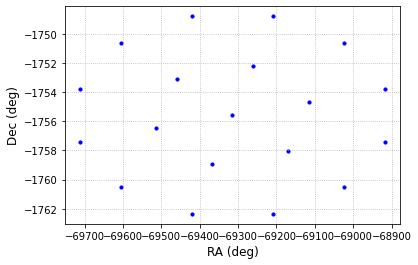

In [205]:
# Calculate each fiber's ra and dec from the nominal ra and dec
# using the fiber's x and y position on the plate
fiber_dec_offset = nominal_dec + fiber_list[:,1] * plate_scale
# Calculate average dec of center of fiber array and the object
avg_dec_rad = np.mean([obj.dec.rad + fiber_dec_offset[0], obj.dec.rad])
fiber_ra_offset = nominal_ra + fiber_list[:,0] * plate_scale / np.cos(avg_dec_rad)
fiber_dec_offset = fiber_dec_offset * 206265
fiber_ra_offset = fiber_ra_offset * 206265

# Plot fiber positions on sky
plt.figure()
plt.scatter(fiber_ra_offset, fiber_dec_offset, s=10, color='b')
#plt.scatter(obj.ra.deg, obj.dec.deg, s=100, color='r')
plt.xlabel('RA (deg)', fontsize=12)
plt.ylabel('Dec (deg)', fontsize=12)
plt.grid(linestyle='dotted')
plt.show()

In [206]:
# Calculate each fiber's ra and dec from the nominal ra and dec
# using the fiber's x and y position on the plate
fiber_dec_offset2 = nominal_dec + fiber_list[:,1] * plate_scale
# Calculate average dec of center of fiber array and the object
#avg_dec_rad2 = np.mean([obj.dec.rad + fiber_dec_offset[0], obj.dec.rad])
fiber_ra_offset2 = nominal_ra + fiber_list[:,0] * plate_scale / np.cos(obj.dec.rad)
fiber_dec_offset2 = fiber_dec_offset2 * 206265
fiber_ra_offset2 = fiber_ra_offset2 * 206265

Below, we plot the fiber offsets with only using the dec at the obj_now (blue) and with using the average of the camera's dec and the obj_now dec (red). The latter is more accurate, we will use that. (*Actually, do we need to just use the camera's dec, now that I think about it a bit more?*)

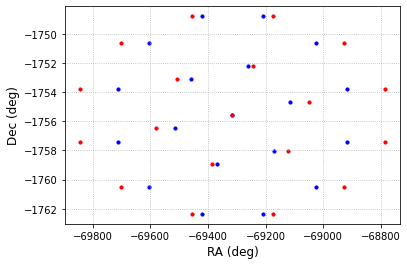

In [207]:
# plot fiber_dec_offset and fiber_ra_offset
# in addition to fiber_dec_offset2 and fiber_ra_offset2
plt.figure()
plt.scatter(fiber_ra_offset, fiber_dec_offset, s=10, color='b')
plt.scatter(fiber_ra_offset2, fiber_dec_offset2, s=10, color='r')
plt.xlabel('RA (deg)', fontsize=12)
plt.ylabel('Dec (deg)', fontsize=12)
plt.grid(linestyle='dotted')
plt.show()

In [208]:
# Calculate fiber distance from center of fiber array, then convert to radians using plate scale
fiber_dist = np.sqrt(fiber_list[:,0]**2 + fiber_list[:,1]**2) * plate_scale
# Calculate fiber angle from center of fiber array (angle from +y axis)
fiber_angle = np.arctan2(fiber_list[:,0], fiber_list[:,1])

In [209]:
# Use astropy coordinate offsets to calculate RA/Dec based on fiber_dist and fiber_angle
fiber_positions = obj_now.directional_offset_by(fiber_angle*u.rad, fiber_dist*u.rad)

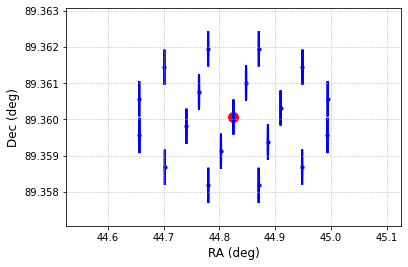

In [213]:
# Plot fiber positions on sky
plt.figure()
plt.scatter(fiber_positions.ra.deg, fiber_positions.dec.deg, s=10, color='b')
plt.scatter(obj_now.ra.deg, obj_now.dec.deg, s=100, color='r')
plt.xlabel('RA (deg)', fontsize=12)
plt.ylabel('Dec (deg)', fontsize=12)

# Plot circles of radius 3 arcsec around each fiber
for i in range(len(fiber_positions)):
    circle = plt.Circle((fiber_positions.ra.deg[i], fiber_positions.dec.deg[i]), 3.5/2/3600, color='b', fill=False, linewidth=2)
    plt.gcf().gca().add_artist(circle)
plt.grid(linestyle='dotted')

# Zoom out a bit
plt.xlim([obj_now.ra.deg-0.3, obj_now.ra.deg+0.3])
plt.ylim([obj_now.dec.deg-0.003, obj_now.dec.deg+0.003])
plt.show()

Above looks like it doesn't work, but it is working as expected... We still need to work on projecting the angular size of the fiber onto the sky, especially in the RA axis near the pole. The above code works reasonably well for Arcturus, but not for Polaris. Perhaps another solution is to download an image from DSS and draw on that? Or maybe try this in Aladin Lite (which will take some javascript coding).